# **Note**
# - Please Don't Test your codes here!
# - Copy to a test version and Paste the stable one back for the final code

In [ ]:
#@title GPU define
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Tue May  5 20:34:20 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [ ]:
#@title Import data from google drive
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.model_zoo as model_zoo
from collections import OrderedDict
import matplotlib as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
driver = GoogleDrive(gauth)

downloaded = driver.CreateFile({'id':'1X97dcpmWKOzXp6-YBAB42DL1zzeCBwIQ'})
downloaded.GetContentFile('train_abstracts.csv')

downloaded = driver.CreateFile({'id':'1jpa95rMM-9TxfUCg9dKZbjAL-qv6wOx2'})
downloaded.GetContentFile('train_relations.csv')

downloaded = driver.CreateFile({'id':'1oasiLvRk281QSCeZ6orbxvfESqbU1kZD'})
downloaded.GetContentFile('training_entities.csv')

downloaded = driver.CreateFile({'id':'1Vj3SV7V1wEhIsU1LgwlmqPpTfTKib_xk'})
downloaded.GetContentFile('glove.6B.50d.txt')


from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
#@title Hyperparameters
MAX_SNET_LENGTH = 50
EMBEDDING_DIM = 50


## Import Data
Input: train_abstracts = [ID][Title][Abstract] = [1020 x 3]

Output: train_relations = [ID][CPR][Eval][Type][Arg1][Arg2] = [6437 x 6]


In [ ]:
#@title Load files
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width',300)

train_abstracts = pd.read_csv("train_abstracts.csv")
train_relations = pd.read_csv("train_relations.csv")
train_entities = pd.read_csv('training_entities.csv')
#print(train_abstracts)
#print(train_relations)
#print(train_entities)

In [ ]:
#@title Label CPR for Title
abstracts_sort = train_abstracts[['ID','Title']].sort_values(by=['ID'])
#print(abstracts_sort)
relations_sort = train_relations[['ID','CPR']].sort_values(by=['ID'])
#print(relations_sort)
#print(abstracts_sort['Title'][0])
relations_sort['CPR'] = relations_sort['CPR'].map(lambda x: x.lstrip('CPR:'))
def OneHotLabel(abstracts, CPR):
  labels = torch.zeros(len(abstracts),11)
  count = 0
  for index in range(len(abstracts)):
    ID = abstracts.iat[index,0]
    #print(ID)
    while ID == CPR.iat[count,0]:
      labels[index, int(CPR.iat[count,1])] = 1   # assign label
      if count < len(CPR)-1:
        count += 1 
      else:
        break
  return labels
title_labels = OneHotLabel(abstracts_sort,relations_sort)

In [ ]:
#@title Chemical-Gene Dictionary
Chem_Gene = train_entities[['Type','Name']]    # Extract 'type' and 'name' colum
Chem_Gene['Type'] = Chem_Gene['Type'].map(lambda x: x.rstrip('-N-Y'))    # strip -N and -Y
Chem_Gene['Name'] = Chem_Gene['Name'].str.lower()     # lowercase for Name
Chem = Chem_Gene.loc[Chem_Gene['Type']=='CHEMICAL']   # Extract chemicals
Gene = Chem_Gene.loc[Chem_Gene['Type']=='GENE']   # Extract chemicals
Chem_dict = pd.DataFrame(Chem.Name.sort_values().unique())   # find unique Chemical
Gene_dict = pd.DataFrame(Gene.Name.sort_values().unique())   # find unique Gene
Chem_dict.columns=['Name']     # Chem dictionary
Gene_dict.columns=['Name']     # Gene dictionary
#print(Chem_dict)
#print(Gene_dict)

# Generate entities and relations
entities_all = train_entities.sort_values(by=['ID'])
relations_all = train_relations.sort_values(by=['ID'])
#print(relations_all)
relations_all['Arg1'] = relations_all['Arg1'].map(lambda x: x.lstrip('Arg1:'))   # strip 'Arg1:'
relations_all['Arg2'] = relations_all['Arg2'].map(lambda x: x.lstrip('Arg2:'))   # strip 'Arg2:'
relations_all['CPR'] = relations_all['CPR'].map(lambda x: x.lstrip('CPR:'))      # strip 'CPR:'
relations_all['Arg1_Name']=""
relations_all['Arg2_Name']=""
relations_all['Type_Label']=""
relations_all['Chemical'] =""
relations_all['Gene'] = ""
relations_uniqueID = pd.unique(relations_all.ID.sort_values())        # create unique ID relations sort by ID
relations_uniqueType = pd.unique(relations_all.Type.sort_values())    # create unique type relations sort by type
relations_uniqueCPR = pd.unique(train_relations.CPR.sort_values())    # create unique CPR relations sort by type

for i, word in enumerate(relations_uniqueType):
  relations_all['Type_Label'][relations_all.Type==word] = i           # label type 

# Preallocation CPR and Gene Map
Chem_Gene_CPR = np.zeros((len(Chem_dict),len(Gene_dict)))
Chem_Gene_Type = np.zeros((len(Chem_dict),len(Gene_dict))) 

for i, number in enumerate(relations_uniqueID):
  relations_section = relations_all.loc[relations_all['ID']==number]
  #print(relations_section)
  entities_section = entities_all.loc[entities_all['ID']==number]
  #print(entities_section)
  for j,index in enumerate(relations_section.index):
    Arg1 = relations_section.loc[index]['Arg1']
    Arg2 = relations_section.loc[index]['Arg2']
    chem = entities_section['Name'][entities_section.Label==Arg1].item().lower()
    gene = entities_section['Name'][entities_section.Label==Arg2].item().lower()
    relations_all.loc[index,'Arg1_Name'] = chem
    relations_all.loc[index,'Arg2_Name'] = gene
    chem_index = Chem_dict['Name'][Chem_dict.Name==chem].index.tolist()
    gene_index = Gene_dict['Name'][Gene_dict.Name==gene].index.tolist()
    relations_all.loc[index,'Chemical'] = chem_index
    relations_all.loc[index,'Gene'] = gene_index
    CPR_index = relations_section.loc[index]['CPR']
    #print(CPR_index)
    Type_index = relations_section.loc[index]['Type_Label']
    #print(Type_index)
    Chem_Gene_CPR[chem_index, gene_index] = CPR_index
    Chem_Gene_Type[chem_index, gene_index] = Type_index
    #print(Chem_Gene_CPR)
    #print(Chem_Gene_Type)
    
print(relations_all)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.p

            ID CPR Eval                    Type Arg1 Arg2                                          Arg1_Name                                          Arg2_Name Type_Label Chemical  Gene
1237   1332478   4   Y   INDIRECT-DOWNREGULATOR   T7  T13                                          ritodrine                         beta 2-adrenergic receptor          8     2722   573
1245   1361547   6   Y               ANTAGONIST   T9  T25                                          dilevalol                                beta 1-adrenoceptor          4     1250   570
1244   1361547   6   Y               ANTAGONIST   T8  T25                                          labetalol                                beta 1-adrenoceptor          4     1852   570
1243   1361547   6   Y               ANTAGONIST   T7  T24                                          labetalol                               beta 2-adrenoceptors          4     1852   576
1238   1361547   2   N                REGULATOR   T1  T23             

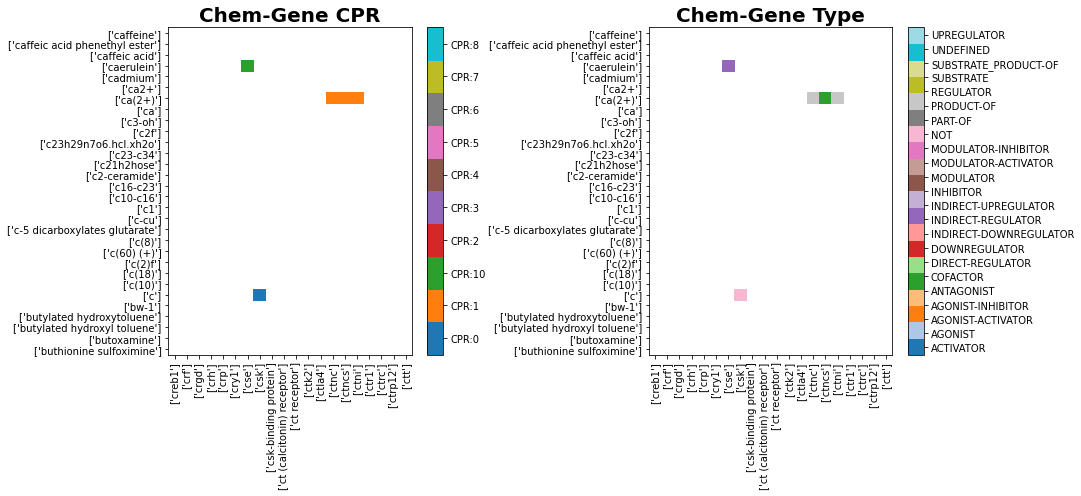

In [ ]:
#@title Plot Database
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(1,2,figsize=[15,7])
CPR = np.where(Chem_Gene_CPR==0,np.nan,Chem_Gene_CPR)
CPRmap = ax[0].pcolor(CPR[870:900,980:1000], cmap='tab10', vmax=10.5, vmin=0.5)
gene = Gene_dict[980:1000].to_numpy()
chem = Chem_dict[870:900].to_numpy()
ax[0].set_xticklabels(gene, minor=False, rotation=90)
ax[0].set_yticklabels(chem, minor=False)
ax[0].set_title('Chem-Gene CPR', fontsize =20, fontweight='bold')
ax[0].set_xticks(np.arange(len(gene)) + 0.5, minor=False)
ax[0].set_yticks(np.arange(len(chem)) + 0.5, minor=False)
CPRColorbar = fig.colorbar(CPRmap, ax=ax[0],ticks=np.arange(1,11))
CPRColorbar.ax.set_yticklabels(relations_uniqueCPR)  # vertically oriented colorbar

Type = np.where(Chem_Gene_Type==0,np.nan,Chem_Gene_Type)
Typemap = ax[1].pcolor(Type[870:900,980:1000], cmap='tab20', vmax=23.5, vmin=0.5)
gene = Gene_dict[980:1000].to_numpy()
chem = Chem_dict[870:900].to_numpy()
ax[1].set_xticklabels(gene, minor=False, rotation=90)
ax[1].set_yticklabels(chem, minor=False)
ax[1].set_title('Chem-Gene Type', fontsize =20, fontweight='bold')
ax[1].set_xticks(np.arange(len(gene)) + 0.5, minor=False)
ax[1].set_yticks(np.arange(len(chem)) + 0.5, minor=False)
TypeColorbar = fig.colorbar(Typemap, ax=ax[1],ticks=np.arange(1,len(relations_uniqueType)+1))
TypeColorbar.ax.set_yticklabels(relations_uniqueType)  # vertically oriented colorbar
# # put the major ticks at the middle of each cell
# # and the x-ticks on top
# ax.xaxis.tick_top()
# ax.invert_yaxis()

plt.tight_layout()
path = F"/content/gdrive/My Drive/Colab Notebooks/Knowledge.png"
fig.savefig(path, dpi=300) 
plt.show()

## Import GloVe 

Use pretrained GloVe 6B-50d to embeded words
* 

In [ ]:
#@title GloVe Embedding
MAX_SNET_LENGTH = 50
EMBEDDING_DIM = 50

class Word_Embedding():
  def __init__(self, file, max_sent_length = MAX_SNET_LENGTH, embedding_dim=EMBEDDING_DIM):
    self.max_sent_length = max_sent_length
    self.embedding_dim = embedding_dim
    self.embeddings_dict = {}
    self.embeddings_index = {}
    self.word2vec = torch.zeros(max_sent_length, embedding_dim)   # pre-allocation

    from nltk.tokenize import TreebankWordTokenizer
    self.tokenizer = TreebankWordTokenizer()
    with open(file, 'r') as f:
        count = 0 
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], "float32")
            self.embeddings_dict[word] = vector
            self.embeddings_index[word] = count
            count += 1

  def get_embedding_vec(self, word):
    idx = self.embeddings_index.get(word.lower(), -1)           
    if idx == -1:
        return np.zeros((self.embedding_dim, ), dtype='float32')     
    return self.embeddings_dict[word.lower()]

  def sent_embedding(self, sentence):
    sent = self.tokenizer.tokenize(sentence)          # sentence split into words 
    for i, word in enumerate(sent): 
      vector = self.get_embedding_vec(word)           # get vector from dict
      self.word2vec[i] = torch.from_numpy(vector)                 
    return self.word2vec

  def batch_embedding(self, data, column):          
    batch2vec = torch.zeros(len(data), self.max_sent_length, self.embedding_dim)
    for i in range(len(data)):
      sent = data.iat[i,column]
      vectors = self.sent_embedding(sent)
      batch2vec[i] = vectors
    return batch2vec

word_embedding = Word_Embedding('glove.6B.50d.txt')
title_dataset = word_embedding.batch_embedding(train_abstracts, column=1)

In [ ]:
#@title Separate abstracts and swap chemical and gene
class SEP_Abstract():  
  def __init__(self, relations=relations_all, Gene_dict=Gene_dict, Chem_dict=Chem_dict, CPR=Chem_Gene_CPR, Type=Chem_Gene_Type):
    self.sentence = pd.DataFrame({'ID':[],'Title':[],'Sentence':[],'Knowledge':[],'Answer':[]})
    self.sentence = self.sentence.astype({'ID':'int64'})
    relations['Check']=0
    self.relations = relations
    Gene_dict['Type']='gene'
    Chem_dict['Type']='chemical'
    self.Gene_dict = dict(zip(Gene_dict.Name, zip(Gene_dict.Type, Gene_dict.index)))
    self.Chem_dict = dict(zip(Chem_dict.Name, zip(Chem_dict.Type, Chem_dict.index)))
    self.Chem_Gene_CPR = CPR
    self.Chem_Gene_Type = Type

    # Load nltk sentence splitter package
    import nltk
    from nltk.tokenize import TreebankWordTokenizer
    nltk.download('punkt')
    self.sentence_splitter = nltk.data.load('tokenizers/punkt/english.pickle')
    self.tokenizer = TreebankWordTokenizer()
  
  def find_knowledge(self, chem_list, gene_list, relations):
    knowledge = []
    answer = []
    for i, (chem, chem_num) in enumerate(chem_list):
      for i, (gene, gene_num) in enumerate(gene_list):
        # generate answer in relations
        indexes = relations[(relations['Chemical']==chem_num) & (relations['Gene']==gene_num)].index.tolist()
        if len(indexes) != 0:
          for i, index in enumerate(indexes):
            self.relations.loc[index,'Check']=1
            CPR = int(self.relations.iloc[index]['CPR'])
            if CPR not in answer:
              answer.append(CPR)
        # generate knowledge sentence
        CPR = int(self.Chem_Gene_CPR[chem_num, gene_num])
        Type = int(self.Chem_Gene_Type[chem_num, gene_num])
        if CPR != 0:
          sent_list = [chem, chem_num, gene, gene_num, 'CPR:', CPR, 'Type:', Type]
          sentence = ' '.join(map(str, sent_list))
          if sentence not in knowledge:
            knowledge.append(sentence)
    answer.sort()
    if len(answer)==0:
      answer.append(0)
    if knowledge == []:
      knowledge = 'not match'     # if gene-chemical not match database, giving "not match"
    else:
      knowledge = ' '.join(map(str, knowledge))
    return knowledge, answer
  
  def swap_word(self, one_sent, relations):
    translation = []
    chem_list=[]
    gene_list=[]

    vocabs = one_sent.split()
    max_len = 10
    index = 0
    while index < len(vocabs):
      for i in range(max_len, 0, -1):
        phrase = ' '.join(vocabs[index:index+i])
        if phrase in self.Chem_dict:
          word = self.Chem_dict[phrase]
          translation.append(word)
          chem_list.append(word)  
          index += i
          break
        elif phrase in self.Gene_dict:
          word = self.Gene_dict[phrase]
          translation.append(word)
          gene_list.append(word)
          index += i
          break
        else:
          translation.append(vocabs[index])
          index += 1
    if (chem_list!=[] and gene_list!=[]):
      knowledge, answer = self.find_knowledge(chem_list, gene_list, relations)
    else:
      knowledge = 'not found'    # if no gene-chemical pair, giving "not found"
      answer = [0]
    swap_sent = ' '.join(map(str, translation))
    return swap_sent, knowledge, answer

  def split_sent(self, one_abstract):
    sentences = self.sentence
    ID = one_abstract['ID']
    title = one_abstract['Title'].lower()
    abstract = one_abstract['Abstract'].lower()
    sents = self.sentence_splitter.tokenize(abstract)
    for i, one_sent in enumerate(sents):
      swap_sent, knowledge, answer = self.swap_word(one_sent, self.relations.loc[self.relations['ID']==ID])
      ans = np.asarray(answer)
      sentences = sentences.append({'ID':ID, 'Title':title, 'Sentence':swap_sent, 'Knowledge':knowledge, 'Answer':ans}, ignore_index=True)
    return sentences

  def split_abstract(self, papers):
    abstract_sents = self.sentence
    for i in range(len(papers)):
      one_abstract = papers.iloc[i]
      sep_sents = self.split_sent(one_abstract)
      abstract_sents = abstract_sents.append(sep_sents, ignore_index=True)
    abstract_sents.astype({'ID':'int16'}).dtypes
    return abstract_sents, self.relations

sep_abstract = SEP_Abstract()
sentence_all, relations_label = sep_abstract.split_abstract(train_abstracts)
sentence_all

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,ID,Title,Sentence,Knowledge,Answer
0,16357751,selective costimulation modulators: a novel ap...,t cells have a central role in the orchestrati...,not found,[0]
1,16357751,selective costimulation modulators: a novel ap...,the requirement for a dual signal for t-cell a...,not found,[0]
2,16357751,selective costimulation modulators: a novel ap...,this approach is mechanistically distinct from...,not found,[0]
3,16357751,selective costimulation modulators: a novel ap...,the fusion protein abatacept is a selective co...,not found,[0]
4,16357751,selective costimulation modulators: a novel ap...,abatacept dose-dependently reduces t-cell prol...,not found,[0]
...,...,...,...,...,...
9246,17611273,methylphenidate administration to juvenile rat...,"in medial striatum, th-ir decreased by 21%, an...",not found,[0]
9247,17611273,methylphenidate administration to juvenile rat...,"at pnd135, mph-exposed rats exhibited decrease...",not found,[0]
9248,17611273,methylphenidate administration to juvenile rat...,neither pnd35 nor pnd135 rats showed major str...,not found,[0]
9249,17611273,methylphenidate administration to juvenile rat...,these findings suggest that developmental expo...,not found,[0]


In [ ]:
#@title test
pd.set_option('display.width',200)
pd.set_option('display.max_rows', 200)
print(relations_label)
aa = (relations_label['Check'] == 1).astype(int).sum(axis=0)
bb = len(relations_label)
aa/bb

            ID CPR Eval                    Type Arg1 Arg2                        Arg1_Name                   Arg2_Name Type_Label Chemical  Gene  Check
1237   1332478   4   Y   INDIRECT-DOWNREGULATOR   T7  T13                        ritodrine  beta 2-adrenergic receptor          8     2722   573      1
1245   1361547   6   Y               ANTAGONIST   T9  T25                        dilevalol         beta 1-adrenoceptor          4     1250   570      1
1244   1361547   6   Y               ANTAGONIST   T8  T25                        labetalol         beta 1-adrenoceptor          4     1852   570      1
1243   1361547   6   Y               ANTAGONIST   T7  T24                        labetalol        beta 2-adrenoceptors          4     1852   576      1
1238   1361547   2   N                REGULATOR   T1  T23                      ici 118,551         beta 2-adrenoceptor         18     1709   575      1
...        ...  ..  ...                     ...  ...  ...                              .

0.5151468075190306

In [ ]:
#@title Split dataset into train and validation

from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils import data

class RPDataset(data.Dataset):
  def __init__(self, x, y):
    self.x = x
    self.y = y
  def __len__(self):
    return len(self.x)
  def __getitem__(self, index):
    inputs = self.x[index]
    outputs = self.y[index]
    return inputs.to(device), outputs.to(device)

# Creating data indices for training and validation splits:
def indices_generation(dataset, batch_size, validation_split, shuffle_dataset=True):
  random_seed= 42
  dataset_size = len(dataset)
  indices = list(range(dataset_size))
  split = int(np.floor(validation_split * dataset_size))
  if shuffle_dataset :
      np.random.seed(random_seed)
      np.random.shuffle(indices)
  train_indices, val_indices = indices[split:], indices[:split]
  return train_indices, val_indices

batch_size = 50
train_indices, val_indices = indices_generation(title_dataset, batch_size, 0.2)

x_train = title_dataset[train_indices]
y_train = title_labels[train_indices]
x_valid = title_dataset[val_indices]
y_valid = title_labels[val_indices]

# Creating RPDdata samplers and loaders:
train_set = RPDataset(x_train, y_train)
val_set = RPDataset(x_valid, y_valid)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,shuffle=True)
valid_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size,shuffle=True)

In [ ]:
#@title Training data
class Title_Classifer(nn.Module):
  def __init__(self, embed_size, hidden_size, num_layer=2, dropout=0.5, num_class=10):
    super(Title_Classifer, self).__init__()

    self.gru = nn.GRU(embed_size, hidden_size, num_layers=num_layer,
                      batch_first=True, dropout=dropout, bidirectional=True)
    self.reduction = nn.Linear(num_layer*2, 1) 
    self.classifer = nn.Linear(hidden_size, num_class)
  
  def forward(self, input):
    """
    input: [batch, length, hidden]
    hidden: [batch, num_layer*directions, hidden]
    output: [batch, Length, Hidden*direction]
    finals: [num_layer*directions, batch, hidden]    
    """
    input = input.to(device)
    outputs, finals = self.gru(input)
    dense = self.reduction(finals.permute(1,2,0))
    out_class = self.classifer(dense.squeeze(2))    
    return out_class 

from sklearn.metrics import precision_recall_fscore_support
class LossComputes:
  def __init__(self, model, clip, opt=None):
    self.clip = clip
    self.opt = opt
    self.model = model
    self.mse = nn.MSELoss()
    self.sig = nn.Sigmoid()
    self.CE = nn.CrossEntropyLoss()
    self.BCE = nn.BCEWithLogitsLoss()

  def accuracy(self, pred, truth):
    with torch.no_grad(): 
      pred = self.sig(pred).cpu()
      truth = truth.cpu()
      p, r, f1, _ = precision_recall_fscore_support(truth > 0.5, pred > 0.5, average='samples', zero_division=0)
    return p, r, f1

  def __call__(self, pred, truth):

    loss_BCE = self.BCE(pred, truth)
    p,r,f1 = self.accuracy(pred, truth)
    loss = loss_BCE

    if self.opt is not None:
      loss.backward()
      torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.clip)
      self.opt.step()
      self.opt.zero_grad()
    return loss.data.item(), p, r, f1


def run_epoch(data_loader, model, loss_compute, print_every):
  total_loss = 0

  for i, (inputs, truth) in enumerate(data_loader):
    pred = model(inputs)
    loss, p, r, f1 = loss_compute(pred, truth)  
    if model.training and i % print_every == 0:
      print("Epoch Step: %d Loss:%f  Precision:%f  Recall:%f  Score:%f" % (i, loss, p, r, f1))
  return loss, f1

def train(model, num_epochs, learning_rate, print_every=10, clip=1):
  optim = torch.optim.Adam(model.parameters(), lr=learning_rate)

  train_losses = []
  valid_losses = []
  train_f1s = []
  valid_f1s = []

  for epoch in range(num_epochs):
    print("Epoch", epoch)
    model.eval()
    with torch.no_grad():      
      valid_loss, valid_f1 = run_epoch(data_loader=valid_loader, model=model,
                          loss_compute=LossComputes(model, clip, opt=None),
                          print_every=print_every)
      print("Val Determination: %f %f" % (valid_loss, valid_f1))
      valid_losses.append(valid_loss)
      valid_f1s.append(valid_f1)

    model.train()
    train_loss, train_f1 = run_epoch(data_loader=train_loader, model=model,
                          loss_compute=LossComputes(model, clip, optim),
                          print_every=print_every)
    train_losses.append(train_loss)
    train_f1s.append(train_f1)

      # if valid_loss < threshold:
      #   model_save_name = '7-90_class_BCE.pt'
      #   path = F"/content/gdrive/My Drive/Colab Notebooks/{model_save_name}" 
      #   torch.save(denseNet.state_dict(), path)
      #   print('Model Save! threshold: %f' % valid_R2)
      #   threshold = valid_loss
      # else:
      #   continue

  train_f1s = torch.FloatTensor(train_f1s)     
  valid_f1s = torch.FloatTensor(valid_f1s) 
  train_losses = torch.FloatTensor(train_losses)     
  valid_losses = torch.FloatTensor(valid_losses) 
  print('The Best f1 %f' % torch.max(valid_f1s))
  return train_losses, train_f1s, valid_losses, valid_f1s

NUM_EPOCHS = 100
LEARN_RATE = 5e-6

title_gru = Title_Classifer(50, 50).to(device)
train_losses, train_f1s, valid_losses, valid_f1s = train(title_gru, NUM_EPOCHS, LEARN_RATE)



Epoch 0
Val Determination: 0.776912 0.236364
Epoch Step: 0 Loss:0.776469  Precision:0.125714  Recall:0.370333  Score:0.182354
Epoch Step: 10 Loss:0.773735  Precision:0.119524  Recall:0.445000  Score:0.181290
Epoch 1
Val Determination: 0.790683 0.100000
Epoch Step: 0 Loss:0.776866  Precision:0.087143  Recall:0.343333  Score:0.135492
Epoch Step: 10 Loss:0.772513  Precision:0.105238  Recall:0.344667  Score:0.150192
Epoch 2
Val Determination: 0.770408 0.155556
Epoch Step: 0 Loss:0.779084  Precision:0.080476  Recall:0.246667  Score:0.117091
Epoch Step: 10 Loss:0.763589  Precision:0.152381  Recall:0.453667  Score:0.216241
Epoch 3
Val Determination: 0.777227 0.118056
Epoch Step: 0 Loss:0.778543  Precision:0.087619  Recall:0.330000  Score:0.134000
Epoch Step: 10 Loss:0.772565  Precision:0.091429  Recall:0.269333  Score:0.131543
Epoch 4
Val Determination: 0.796126 0.055556
Epoch Step: 0 Loss:0.769972  Precision:0.116667  Recall:0.420000  Score:0.177667
Epoch Step: 10 Loss:0.772882  Precision:0.

In [ ]:
one_title = bert_title[202].unsqueeze(0)
result = title_gru(one_title)
sig = nn.Sigmoid()
ans = sig(result)
ans

NameError: ignored

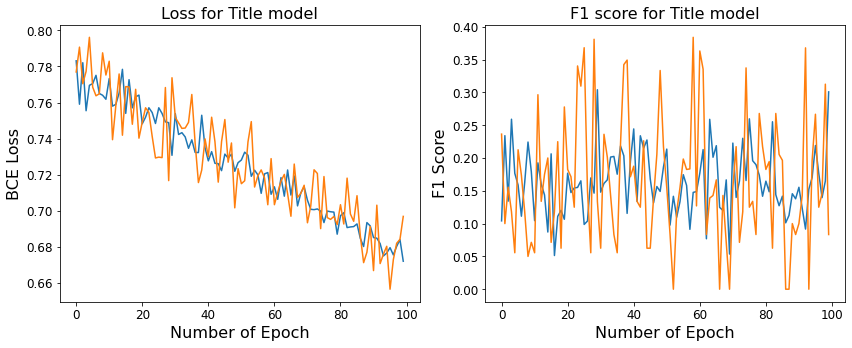

In [ ]:
#@title Plot Title Training
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable

font = {'weight':'normal', 'size':12}
matplotlib.rc('font',**font)

fig, ax = plt.subplots(1,2,figsize=[12,5])
train_loss = ax[0].plot(train_losses)
valid_loss = ax[0].plot(valid_losses)
ax[0].set_title('Loss for Title model', fontsize=16)
ax[0].set_xlabel('Number of Epoch',fontsize=16)
ax[0].set_ylabel('BCE Loss',fontsize=16)

train_acc = ax[1].plot(train_f1s)
valid_acc = ax[1].plot(valid_f1s)
ax[1].set_title('F1 score for Title model', fontsize=16)
ax[1].set_xlabel('Number of Epoch',fontsize=16)
ax[1].set_ylabel('F1 Score',fontsize=16)

plt.tight_layout()
figure_save_name = 'training.png'
path = F"/content/gdrive/My Drive/Course/6.864 NLP/Project/Figures/{figure_save_name}"
fig.savefig(path, dpi=300) 
plt.show()

In [ ]:
#@title Import Bert and BertViz

# Download BertViz 
import sys
!test -d bertviz_repo && echo "FYI: bertviz_repo directory already exists, to pull latest version uncomment this line: !rm -r bertviz_repo"
# !rm -r bertviz_repo # Uncomment if you need a clean pull from repo
!test -d bertviz_repo || git clone https://github.com/jessevig/bertviz bertviz_repo
if not 'bertviz_repo' in sys.path:
  sys.path += ['bertviz_repo']
!pip install regex
!pip install transformers

# import head_view, transformers
from bertviz import head_view
from transformers import BertTokenizer, BertModel

# Define call_html
def call_html():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              "d3": "https://cdnjs.cloudflare.com/ajax/libs/d3/3.5.8/d3.min",
              jquery: '//ajax.googleapis.com/ajax/libs/jquery/2.0.0/jquery.min',
            },
          });
        </script>
        '''))

FYI: bertviz_repo directory already exists, to pull latest version uncomment this line: !rm -r bertviz_repo


In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, BertModel, BertPreTrainedModel
model_version = 'bert-base-uncased'

bert_title = word_embedding.batch_embedding(sentence_all, column=1)
bert_sentence = sentence_all['Sentence'].tolist()
bert_knowledge = sentence_all['Knowledge'].tolist()
bert_Answer = sentence_all['Answer'].tolist()

def bert_combine(sentence, knowledge):
  inputs = [(sentence[i], knowledge[i]) for i in range(len(sentence))]
  return inputs

def bert_decodeAns(bert_Answer):
  bert_labels = torch.zeros((len(bert_Answer),11))
  for i, index in enumerate(bert_Answer):
    bert_labels[i, index] = 1
  return bert_labels

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

bert_labels = bert_decodeAns(bert_Answer)
# sent_inputs = bert_combine(bert_sentence, bert_knowledge)   # combine sentence and knowledge
sent_inputs = bert_sentence                               # only use sentence
bert_batch_inputs = tokenizer.batch_encode_plus(batch_text_or_text_pairs=sent_inputs, add_special_tokens=True, max_length=200,
                                                pad_to_max_length='right')
print(bert_batch_inputs)
bert_input_ids = torch.tensor(bert_batch_inputs['input_ids'], dtype=torch.long)
bert_type_ids = torch.tensor(bert_batch_inputs['token_type_ids'])


In [ ]:
#@title Bert Split dataset into train and validation

from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils import data

class BertDataset(data.Dataset):
  def __init__(self, title, sentence, type_id, labels):
    self.title = title
    self.sentence = sentence
    self.type_id = type_id
    self.labels = labels
  def __len__(self):
    return len(self.sentence)
  def __getitem__(self, index):
    bert_title = self.title[index]
    bert_sent = self.sentence[index]
    bert_type = self.type_id[index]
    bert_labels = self.labels[index]
    return bert_title.to(device), bert_sent.to(device), bert_type.to(device), bert_labels.to(device)

# Creating data indices for training and validation splits:
def indices_generation(dataset, batch_size, validation_split, shuffle_dataset=True):
  random_seed= 42
  dataset_size = len(dataset)
  indices = list(range(dataset_size))
  split = int(np.floor(validation_split * dataset_size))
  if shuffle_dataset :
      # np.random.seed(random_seed)
      np.random.shuffle(indices)
  train_indices, val_indices = indices[split:], indices[:split]
  return train_indices, val_indices

batch_size = 25
train_indices, val_indices = indices_generation(title_dataset, batch_size, 0.3)

title_train = bert_title[train_indices]
sent_train = bert_input_ids[train_indices]
type_train = bert_type_ids[train_indices]
label_train = bert_labels[train_indices]
title_val = bert_title[val_indices]
sent_val = bert_input_ids[val_indices]
type_val = bert_type_ids[val_indices]
label_val = bert_labels[val_indices]

# Creating RPDdata samplers and loaders:
bert_train_set = BertDataset(title_train, sent_train, type_train, label_train)
bert_val_set = BertDataset(title_val, sent_val, type_val, label_val)
bert_train_loader = torch.utils.data.DataLoader(bert_train_set, batch_size=batch_size, shuffle=True)
bert_valid_loader = torch.utils.data.DataLoader(bert_val_set, batch_size=batch_size, shuffle=True)

In [ ]:
class BertMultiClassification(BertPreTrainedModel):
  def __init__(self, config, num_labels=11):
    super(BertMultiClassification, self).__init__(config)
    self.num_labels = num_labels
    self.bert = BertModel(config)
    self.dropout = nn.Dropout(config.hidden_dropout_prob)
    self.classifier = torch.nn.Linear(config.hidden_size, num_labels).to(device)
    self.loss_fc = nn.BCEWithLogitsLoss()
  
  def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, position_ids=None, 
              head_mask=None, inputs_embeds=None, labels=None):
    outputs = self.bert(
        input_ids,
        attention_mask=attention_mask,
        token_type_ids=token_type_ids,
        position_ids=position_ids,
        head_mask=head_mask,
        inputs_embeds=inputs_embeds,
    )
    pooled_output = outputs[1]

    pooled_output = self.dropout(pooled_output)
    logits = self.classifier(pooled_output)
    return logits


In [ ]:
def Bert_run_epoch(data_loader, model, loss_compute, print_every, GRUmodel):
  total_loss = 0

  for i, (title, sent, type_id, label) in enumerate(data_loader):
    pred = model(input_ids=sent, token_type_ids=type_id)
    title_pred = GRUmodel()
    loss, p, r, f1 = loss_compute(pred, label)  
    if model.training and i % print_every == 0:
      print("Epoch Step: %d Loss:%f  Precision:%f  Recall:%f  F1:%f" % (i, loss, p, r, f1))
  return loss, f1

def Bert_train(model, num_epochs, learning_rate, print_every=10, clip=1, GruModel=None):
  optim = torch.optim.Adam(model.parameters(), lr=learning_rate)

  train_losses = []
  valid_losses = []
  train_f1s = []
  valid_f1s = []

  for epoch in range(num_epochs):
    print("Epoch", epoch)
    model.eval()
    with torch.no_grad():      
      valid_loss, valid_f1 = Bert_run_epoch(data_loader=bert_valid_loader, model=model,
                          loss_compute=LossComputes(model, clip, opt=None),
                          print_every=print_every, GRUmodel=GruModel)
      print("Val Determination: %f %f" % (valid_loss, valid_f1))
      valid_losses.append(valid_loss)
      valid_f1s.append(valid_f1)

    model.train()
    train_loss, train_f1 = Bert_run_epoch(data_loader=bert_train_loader, model=model,
                          loss_compute=LossComputes(model, clip, optim),
                          print_every=print_every)
    train_losses.append(train_loss)
    train_f1s.append(train_f1)

  train_f1s = torch.FloatTensor(train_f1s)     
  valid_f1s = torch.FloatTensor(valid_f1s) 
  train_losses = torch.FloatTensor(train_losses)     
  valid_losses = torch.FloatTensor(valid_losses) 
  print('The Best f1 %f' % torch.max(valid_f1s))
  return train_losses, train_f1s, valid_losses, valid_f1s

NUM_EPOCHS = 5
LEARN_RATE = 1e-5

Bert_Model = BertMultiClassification.from_pretrained(model_version).to(device)
train_losses, train_f1s, valid_losses, valid_f1s = Bert_train(Bert_Model, NUM_EPOCHS, LEARN_RATE, GruModel=title_gru)

Epoch 0
Val Determination: 0.666281 0.242063
Epoch Step: 0 Loss:0.668830  Precision:0.156444  Recall:0.940000  F1:0.266857
Epoch Step: 10 Loss:0.488841  Precision:0.760000  Recall:0.760000  F1:0.760000
Epoch Step: 20 Loss:0.360781  Precision:0.920000  Recall:0.920000  F1:0.920000
Epoch 1
Val Determination: 0.324543 0.833333
Epoch Step: 0 Loss:0.328153  Precision:0.840000  Recall:0.840000  F1:0.840000
Epoch Step: 10 Loss:0.303746  Precision:0.800000  Recall:0.800000  F1:0.800000
Epoch Step: 20 Loss:0.237086  Precision:0.920000  Recall:0.920000  F1:0.920000
Epoch 2
Val Determination: 0.242867 0.833333
Epoch Step: 0 Loss:0.208549  Precision:0.920000  Recall:0.920000  F1:0.920000
Epoch Step: 10 Loss:0.199595  Precision:0.880000  Recall:0.880000  F1:0.880000
Epoch Step: 20 Loss:0.184509  Precision:0.880000  Recall:0.880000  F1:0.880000
Epoch 3
Val Determination: 0.140667 1.000000
Epoch Step: 0 Loss:0.232205  Precision:0.760000  Recall:0.760000  F1:0.760000
Epoch Step: 10 Loss:0.186782  Prec

In [ ]:
len(title_batch_inputs)

3

In [ ]:
#@title Bert for title
batch_size = 50
title_inputs = train_abstracts['Title'].tolist()
title_batch_inputs = tokenizer.batch_encode_plus(batch_text_or_text_pairs=title_inputs, add_special_tokens=True, max_length=50,
                                                pad_to_max_length='right')
title_dataset = torch.tensor(title_batch_inputs['input_ids'], dtype=torch.long)
bert_type_ids = torch.tensor(title_batch_inputs['token_type_ids'])
train_indices, val_indices = indices_generation(title_dataset, batch_size, 0.2)
x_train = title_dataset[train_indices]
y_train = title_labels[train_indices]
x_valid = title_dataset[val_indices]
y_valid = title_labels[val_indices]

# Creating RPDdata samplers and loaders:
bert_train_set = RPDataset(x_train, y_train)
bert_val_set = RPDataset(x_valid, y_valid)
bert_train_loader = torch.utils.data.DataLoader(bert_train_set, batch_size=batch_size,shuffle=True)
bert_valid_loader = torch.utils.data.DataLoader(bert_val_set, batch_size=batch_size,shuffle=True)


def Bert_run_epoch(data_loader, model, loss_compute, print_every, GRUmodel=None):
  total_loss = 0

  for i, (sent, label) in enumerate(data_loader):
    pred = model(input_ids=sent)
    
    loss, p, r, f1 = loss_compute(pred, label)  
    if model.training and i % print_every == 0:
      print("Epoch Step: %d Loss:%f  Precision:%f  Recall:%f  F1:%f" % (i, loss, p, r, f1))
  return loss, f1

def Bert_train(model, num_epochs, learning_rate, print_every=10, clip=1, GruModel=None):
  optim = torch.optim.Adam(model.parameters(), lr=learning_rate)

  train_losses = []
  valid_losses = []
  train_f1s = []
  valid_f1s = []

  for epoch in range(num_epochs):
    print("Epoch", epoch)
    model.eval()
    with torch.no_grad():      
      valid_loss, valid_f1 = Bert_run_epoch(data_loader=bert_valid_loader, model=model,
                          loss_compute=LossComputes(model, clip, opt=None),
                          print_every=print_every)
      print("Val Determination: %f %f" % (valid_loss, valid_f1))
      valid_losses.append(valid_loss)
      valid_f1s.append(valid_f1)

    model.train()
    train_loss, train_f1 = Bert_run_epoch(data_loader=bert_train_loader, model=model,
                          loss_compute=LossComputes(model, clip, optim),
                          print_every=print_every)
    train_losses.append(train_loss)
    train_f1s.append(train_f1)

  train_f1s = torch.FloatTensor(train_f1s)     
  valid_f1s = torch.FloatTensor(valid_f1s) 
  train_losses = torch.FloatTensor(train_losses)     
  valid_losses = torch.FloatTensor(valid_losses) 
  print('The Best f1 %f' % torch.max(valid_f1s))
  return train_losses, train_f1s, valid_losses, valid_f1s

NUM_EPOCHS = 5
LEARN_RATE = 1e-6

Bert_Title = BertMultiClassification.from_pretrained(model_version).to(device)
train_losses, train_f1s, valid_losses, valid_f1s = Bert_train(Bert_Title, NUM_EPOCHS, LEARN_RATE)

Epoch 0
Val Determination: 0.708497 0.126984
Epoch Step: 0 Loss:0.703823  Precision:0.096071  Recall:0.303333  F1:0.136746
Epoch Step: 10 Loss:0.658142  Precision:0.102333  Recall:0.211667  F1:0.126476
Epoch 1
Val Determination: 0.647637 0.000000
Epoch Step: 0 Loss:0.643181  Precision:0.166667  Recall:0.301667  F1:0.202238
Epoch Step: 10 Loss:0.629159  Precision:0.169000  Recall:0.214667  F1:0.172317
Epoch 2
Val Determination: 0.617482 0.125000
Epoch Step: 0 Loss:0.609096  Precision:0.183333  Recall:0.183000  F1:0.163429
Epoch Step: 10 Loss:0.593299  Precision:0.276667  Recall:0.256333  F1:0.246000
Epoch 3
Val Determination: 0.580988 0.250000
Epoch Step: 0 Loss:0.593734  Precision:0.255667  Recall:0.201667  F1:0.203714
Epoch Step: 10 Loss:0.564312  Precision:0.226667  Recall:0.135000  F1:0.157048
Epoch 4
Val Determination: 0.553573 0.433333
Epoch Step: 0 Loss:0.562502  Precision:0.316667  Recall:0.178667  F1:0.213429
Epoch Step: 10 Loss:0.539997  Precision:0.220000  Recall:0.135000  F1